In [5]:
#!/usr/bin/env python3

from SheepData import SheepData
import string
import pandas as pd
import numpy as np
import random
import os
import re
import warnings
import joblib
from sklearn import linear_model
from matplotlib import pyplot as plt
from sklearn.exceptions import ConvergenceWarning


class InferPhenotypes():
    def __init__(self):
        self.shd = SheepData()
        self.sheep_folder = self.shd.sheep_folder
        
    def correlation_of_input_variables(self, selected_model:str) -> dict:
        """
        Possible options for the selected_model parameter are:
        - lasso -> runs the model based on a LASSO estimate
        - elastic -> runs the model based on an elastic net estimate
        """
        train, test = self.shd.stratified_data()
        dest_vars = [
            'Alter_Mutter_J', 
            'AblammNr', 
            'LG3_kg', 
            'TZ2_g',
            'Muskeld2_mm', 
            'Fett2_mm',  
            'Fleischigk2',
            'Bem', 
            'Ersch', 
            'Zuchtwert'
        ]
        train.index = pd.MultiIndex.from_arrays(
            [np.repeat("train", train.index.size), train.index], 
            names=["Type", "Original"]
        )
        test.index = pd.MultiIndex.from_arrays(
            [np.repeat("test", test.index.size), test.index],
            names=["Type", "Original"]
        )
        pca_data = pd.concat([train, test], axis=0)
        compress_data = self.shd.pca_compression(
            {1:pca_data}, dest_vars, on_variance_amount=True
        )
        fitted_data = compress_data[1]["data"].loc[
            :,[x for x in compress_data[1]["data"].columns if "pca_" in x]
        ]
        pca_data = pd.concat([pca_data, fitted_data], axis=1)
        x_vars = [
            'Gebmonat', 
            'Gebtyp', 
            'Rasse', 
            'Alter1_Tage',
            'Alter2_Tage',
            'Alter3_Tage',
            'LG1_kg',
            'Muskeld1_mm',
            'Fettd1_mm', 
            'Fleischigk1'
        ]
        _train = pca_data.loc[pd.IndexSlice["train",:],:]
        _test = pca_data.loc[pd.IndexSlice["test",:],:]
        _train.reset_index(drop=False, inplace=True)
        _train.index = _train["Original"]
        _train.drop(["Type", "Original"], axis=1, inplace=True)
        _test.reset_index(drop=False, inplace=True)
        _test.index = _test["Original"]
        _test.drop(["Type", "Original"], axis=1, inplace=True)
        predictions = pd.DataFrame()
        predictors = {}
        train_x = _train.loc[:,x_vars].subtract(_train.loc[:,x_vars].mean())/_train.loc[:,x_vars].std()
        #train_x = _train.loc[:,x_vars]
        pattern = re.compile(r"pca\_[0-9]{1,}")
        compressed_columns = list(filter(pattern.match, _train.columns))
        for var in compressed_columns:
            train_y = _train.loc[:,var]
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore")
                if "lasso" in selected_model:
                    cv_model = linear_model.LassoLarsCV(
                        cv=np.int(np.ceil(len(x_vars)/2))
                    )
                elif "elastic" in selected_model:
                    cv_model = linear_model.ElasticNetCV(
                        cv=np.int(np.ceil(len(x_vars)/2))
                    )
                else:
                    print("no valid choice")
                    continue
                cv_fit = cv_model.fit(train_x, train_y)
                _alpha = cv_fit.alpha_
                if "lasso" in selected_model:
                    model = linear_model.LassoLars(
                        alpha=_alpha, max_iter=2*len(train_x.index)
                    )
                elif "elastic" in selected_model:
                    model = linear_model.ElasticNet(
                        alpha=_alpha, max_iter=2*len(train_x.index)
                    )
                else:
                    continue
            fit = model.fit(train_x, train_y)
            predicted = pd.Series(
                name=var, 
                index=test.index, 
                data=fit.predict(test.loc[:,x_vars])
            )
            predictions = pd.concat(
                [predictions, predicted], 
                axis=1, 
                sort=False
            )
            predictors[var] = fit
        results = self.shd.reverse_pca(
            pca_data=predictions,
            components=compress_data[1]["PC Scores"],
            _mean=train.loc[:,dest_vars].mean(axis=0),
            _columns=np.array(dest_vars)
        )
        results.index = pd.MultiIndex.from_tuples(
            results.index, names=["Type", "Original"]
        )
        predictions.index = pd.MultiIndex.from_tuples(
            predictions.index, names=["Type", "Original"]
        )
        return {"Predictions": predictions, 
                "True values compressed": _test.loc[:,compressed_columns],
                "True values uncompressed": test.loc[:,dest_vars],
                "Results": results, 
                "Predictors": predictors, 
                "Mean": train.loc[:,dest_vars].mean(axis=0),
                "Components": compress_data[1]["PC Scores"]
               } 
    
    def random_x_values(
        self, 
        start_value: int,
        ear_tag_cols:tuple, 
        age_variables:tuple,
        normal_variables:tuple,
        binomial_variables:tuple,
        data:pd.DataFrame,
        diff1:int,
        diff2:int) -> pd.DataFrame:
        r = pd.DataFrame(
            columns=ear_tag_cols + age_variables + normal_variables + binomial_variables,
            index=np.arange(start_value, start_value + 2)
        )
        for column in r.columns:
            if column in ear_tag_cols:
                r.loc[:,column] = self.create_random_eartags(data[column], 2)
            elif column in age_variables:
                continue
            elif column in binomial_variables:
                r.loc[:,column] = np.random.poisson(
                    data[column].quantile(0.4),
                    2
                )
            elif column in normal_variables:
                r.loc[:,column] = np.random.normal(
                    data[column].mean(),
                    data[column].std(),
                    2
                )
        r.loc[:,"Alter2_Tage"] = r.loc[:,"Alter1_Tage"] + diff1
        r.loc[:,"Alter3_Tage"] = r.loc[:,"Alter2_Tage"] + diff2
        return r

    def create_random_values(self, selected_model:str, length_of_new=40) -> pd.DataFrame:
        """
        The options for the selected_model parameter are: 
        - "lasso"
        - "elastic"
        """
        if length_of_new % 2 != 0:
            print("Even number required")
            return None
        original = self.shd.data_cleaning()
        predict = self.correlation_of_input_variables(
            selected_model=selected_model
        )
        normal_variables = (
            'LG1_kg',
            "Rasse",
            'Muskeld1_mm',
            'Fettd1_mm', 
            'Fleischigk1'
        )
        binomial_variables = (
            "Gebmonat",
            "Gebtyp",
            "Alter1_Tage"
        )
        predicted_variables = ( 
            'Alter_Mutter_J', 
            'AblammNr', 
            'LG3_kg', 
            'TZ2_g',
            'Muskeld2_mm', 
            'Fett2_mm',  
            'Fleischigk2',
            'Bem', 
            'Ersch', 
            'Zuchtwert'
        )
        ear_tag_cols = ("Nummer", "Vater", "Mutter")
        age_variables = ("Alter2_Tage", "Alter3_Tage")
        diff1 = np.unique(original["Alter2_Tage"] - original["Alter1_Tage"])[0]
        diff2 = np.unique(original["Alter3_Tage"] - original["Alter2_Tage"])[0]
        prediction_x = [
            'Gebmonat', 
            'Gebtyp', 
            'Rasse', 
            'Alter1_Tage',
            'Alter2_Tage',
            'Alter3_Tage',
            'LG1_kg',
            'Muskeld1_mm',
            'Fettd1_mm', 
            'Fleischigk1'
        ]
        """
        The prediction_x list of variables is a bunch of variables which is autogenerated 
        based on random distributions. These variables are essentially generated in the 
        random_x_values() function.
        """
        results = pd.DataFrame()
        for i in range(1, length_of_new):
            if i % 2 == 1:
                while True:
                    quality_controlled = self.control_for_random_data(
                        i,
                        predict=predict,
                        prediction_x=prediction_x,
                        predicted_variables=predicted_variables,
                        ear_tag_cols=ear_tag_cols, 
                        age_variables=age_variables, 
                        normal_variables=normal_variables, 
                        binomial_variables=binomial_variables, 
                        data=original, 
                        diff1=diff1, 
                        diff2=diff2)
                    if quality_controlled is None:
                        continue
                    elif quality_controlled.index.size < 2:
                        continue
                    else:
                        results = pd.concat([results, quality_controlled], axis=0)
                        break
            else:
                continue
        return results

    def control_for_random_data(
        self, 
        i:int, 
        predict:dict,
        prediction_x:list,
        predicted_variables:list,
        ear_tag_cols:tuple, 
        age_variables:tuple, 
        normal_variables:tuple, 
        binomial_variables:tuple, 
        data:pd.DataFrame, 
        diff1:int, 
        diff2:int):
        x_vars = self.random_x_values(
            start_value=i,
            ear_tag_cols=ear_tag_cols,
            age_variables=age_variables,
            normal_variables=normal_variables,
            binomial_variables=binomial_variables,
            data=data,
            diff1=diff1,
            diff2=diff2
        )
        pca_compressed = pd.DataFrame(
            columns=list(predict["Predictors"].keys())
        )
        normalized = x_vars.loc[:,prediction_x].subtract(
            x_vars.loc[:,prediction_x].mean())/x_vars.loc[:,prediction_x].std()
        for _column in predict["Predictors"].keys():
            _predictor = predict["Predictors"][_column]
            pca_compressed[_column] = _predictor.predict(normalized.fillna(0).values)
        predicted = self.shd.reverse_pca(
            pca_data=pca_compressed,
            components=predict["Components"],
            _mean=predict["Mean"],
            _columns=predicted_variables
        )
        predicted.index = x_vars.index
        x_vars = pd.concat([x_vars, predicted], axis=1)
        x_vars.dropna(how="all", axis=0, inplace=True)
        quality_controlled = self.predicted_quality_control(
            x_vars, 
            data,
            check_columns=age_variables + normal_variables + binomial_variables
        )
        return quality_controlled

    def predicted_quality_control(self, data:pd.DataFrame, original:pd.DataFrame, check_columns:tuple):
        data = data.astype(np.float64)
        for index in data.index:
            r = []
            for column in check_columns:
                if abs(original.loc[:,column].mean() - data.loc[index,column]) <= original[column].std():
                    r.append(1)
                else:
                    r.append(0)
            if sum(r) < len(check_columns)/2:
                data.drop(index, inplace=True, axis=0)
        if data.index.size > 0:    
            data["Alter_Mutter_J"] = np.ceil(data["Alter_Mutter_J"])
            data["AblammNr"] = np.floor(data["AblammNr"])
            data.loc[data["Zuchtwert"] > original["Zuchtwert"].mean() + original["Zuchtwert"].std(), "Zuchtwert"] = 0
            data.loc[data["Zuchtwert"] < original["Zuchtwert"].mean() - original["Zuchtwert"].std(), "Zuchtwert"] = 0
            data["Rasse"] = data["Rasse"].round(0)
            data.loc[(data["Rasse"] > 4) | (data["Rasse"] < 1), "Rasse"] = np.random.randint(
                1, 4, data.loc[(data["Rasse"] > 4) | (data["Rasse"] < 1), "Rasse"].index.size
            )
            data.loc[(data["Gebmonat"] == 0) & (data["Alter1_Tage"] < data["Alter1_Tage"].quantile(0.4)), "Gebmonat"] = 2
            data.loc[(data["Gebmonat"] == 0) & (data["Alter1_Tage"] >= data["Alter1_Tage"].quantile(0.4)), "Gebmonat"] = 1
            data.loc[(data["Gebtyp"] == 0), "Gebtyp"] = np.random.randint(
                1, 3, data.loc[(data["Gebtyp"] == 0), "Gebtyp"].index.size
            )
            return data
        else:
            return None

    def create_random_eartags(self, values, required_length) -> np.int64:
        l = []
        for nummer in np.random.choice(values, size=required_length):
            country = str(nummer)[:3]
            l.append(
                country + "".join(random.SystemRandom().choice(string.digits) for _ in range(14))
            )
            # The solution to this problem of creating numeric strings of designated lengths has 
            # been discussed extensively on stackoverflow. The solution originates from:
            # https://stackoverflow.com/questions/2257441/random-string-generation-with-upper-case-letters-and-digits/23728630#23728630
        return np.int64(l)
    
    def infer_data(
        self, 
        selected_model:str, 
        corrected:bool, 
        length_of_new=10, 
        sort_by_breed=False):
        x_variables = self.create_random_values(
            selected_model=selected_model, 
            length_of_new=length_of_new
        )
        if corrected is True and sort_by_breed is True:
            trained_model_folders = [
                x for x in os.listdir(
                    os.path.join(self.sheep_folder, "model", "corrected", "sorted")
                ) if os.path.isdir(os.path.join(self.sheep_folder, "model", "corrected", "sorted", x))
            ]
            path = os.path.join(self.sheep_folder, "model", "corrected", "sorted")
        elif corrected is True and sort_by_breed is False:
            trained_model_folders = [
                x for x in os.listdir(
                    os.path.join(self.sheep_folder, "model", "corrected", "unsorted")
                ) if os.path.isdir(os.path.join(self.sheep_folder, "model", "corrected", "unsorted", x))
            ]
            path = os.path.join(self.sheep_folder, "model", "corrected", "unsorted")
        elif corrected is False and sort_by_breed is True:
            trained_model_folders = [
                x for x in os.listdir(
                    os.path.join(self.sheep_folder, "model", "uncorrected", "sorted")
                ) if os.path.isdir(os.path.join(self.sheep_folder, "model", "uncorrected", "sorted", x))
            ]
            path = os.path.join(self.sheep_folder, "model", "uncorrected", "sorted")
        else:
            trained_model_folders = [
                x for x in os.listdir(
                    os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted")
                ) if os.path.isdir(os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted", x))
            ]
            path = os.path.join(self.sheep_folder, "model", "uncorrected", "unsorted")
        if "fattening" in trained_model_folders:
            if sort_by_breed is True:
                sorting = "sorted"
            else:
                sorting = "unsorted"
            fattening_results = self.__predict_phenotypes(
                selected_model=selected_model,
                corrected=corrected,
                sorting=sorting, 
                directories=path,
                dataset="fattening",
                x_variables=x_variables)
        if "slaughter" in trained_model_folders:
            try:
                slaughter_results = self.__predict_phenotypes(
                    selected_model=selected_model,
                    corrected=corrected,
                    sorting=sorting,
                    dataset="slaughter",
                    directories=path,
                    x_variables=fattening_results
                )
                slaughter_results.drop(
                    [col for col in slaughter_results.columns if col in fattening_results.columns], 
                    axis=1, 
                    inplace=True
                )
                res = pd.concat([fattening_results, slaughter_results], axis=1)
                return res
            except NameError:
                if sort_by_breed is True:
                    sorting = "sorted"
                else:
                    sorting = "unsorted"
                slaughter_results = self.__predict_phenotypes(
                    selected_model=selected_model,
                    corrected=corrected,
                    sorting=sorting,
                    dataset="slaughter",
                    directories=path,
                    x_variables=x_variables
                )
                return slaughter_results
    
    def __predict_phenotypes(
        self, 
        selected_model:str, 
        corrected:bool,
        sorting:str, 
        dataset:str, 
        directories:str,
        x_variables:pd.DataFrame) -> pd.DataFrame:
        _path = directories.split("/")
        _path.append(dataset)
        path = "/".join(_path)
        model_pattern = re.compile(r"%s\_[a-zA-Z0-9\_]+.joblib"%re.escape(selected_model))
        pca_pattern = re.compile(r"pca\_[0-9]+")
        models = [
            x for x in os.listdir(path) if model_pattern.match(x)
        ]
        _df = pd.DataFrame(index=x_variables.index)
        if "slaughter" in dataset:
            x_vars = x_variables.loc[
                :,[x for x in x_variables.columns if x not in self.shd.slaughter_vars]
            ]
        if "fattening" in dataset:
            x_vars = x_variables.loc[
                :,[x for x in x_variables.columns if x not in self.shd.raising_vars]
            ]
        x_vars_centered = x_vars.subtract(x_vars.mean())/x_vars.std()
        for model in models:
            _model = joblib.load(
                os.path.join(self.sheep_folder, path, model)
            )
            name = "_".join(model.split(".")[0].split("_")[1:])
            if not pca_pattern.match(name):
                if "slaughter" in dataset and name in self.shd.slaughter_vars:
                    _df[name] = _model.predict(x_vars_centered.fillna(0))
                elif "fattening" in dataset and name in self.shd.raising_vars:
                    _df[name] = _model.predict(x_vars_centered.fillna(0))
                else:
                    continue
            else:
                _df[name] = _model.predict(x_vars_centered.fillna(0))
        reversed = self.__reverse_pca_to_original(
            data=_df[[col for col in _df.columns if pca_pattern.match(col)]],
            sorting=sorting,
            destination=dataset,
            path=path
        )
        res = pd.concat([x_vars, reversed], axis=1)
        if len([col for col in _df.columns if not pca_pattern.match(col)]) > 0:
            for _col in [col for col in _df.columns if not pca_pattern.match(col)]:
                res = pd.concat([res, _df[_col]], axis=1)
        return res

    def __reverse_pca_to_original(
        self, 
        data:pd.DataFrame,
        destination:str,
        path:str,
        sorting:str) -> pd.DataFrame:
        _eigenvalues = pd.read_csv(
            os.path.join(path, "Eigenvalues.csv"), 
            index_col=0,
            header=0
        )
        _mean = pd.read_csv(
            os.path.join(path, "Mean.csv"), 
            index_col=0,
            header=0
        )
        pc_scores = pd.read_csv(
            os.path.join(path, "PCScores.csv"), 
            index_col=[0,1],
            header=0
        )
        res = self.shd.reverse_pca(
            pca_data=data,
            components=pc_scores,
            _mean=_mean,
            _columns=_mean.index
        )
        return res

Nummer              Vater             Mutter  Alter2_Tage  \
488  27685574525410420  27608222982816225  27634070523807263          173   
498  27688757409174664  27652098142341955  27637788853079929          144   
244  27632305086605521  27650313629274000  27601826367518815          178   
340  27650594451567573  27603503210388707  27615575816745299          158   
293  27676491614338862  27622469140022838  27616008333355309          166   
..                 ...                ...                ...          ...   
254  27602226325427094  27676189804369609  27666527892111026          131   
56   27684774437416442  27667172039034919  27690999081367300          123   
342  27639928473379976  27687228213319223  27612820452467663          146   
353  27687646612373049  27690142849568574  27642037715904888          161   
390  27692563355439167  27635285291461690  27670889806033045          166   

     Alter3_Tage  Gebmonat  Gebtyp  Alter1_Tage  Rasse  Alter_Mutter_J  ...  \
488          180         1       3          117      1             1.0  ...   
498          151         1       3           88      1             1.0  ...   
244          185         1       1          122      1             1.0  ...   
340          165         2       2          102      1             1.0  ...   
293          173         2       3          110      1             1.0  ...   
..           ...       ...     ...          ...    ...             ...  ...   
254          138         2       3           75      4             1.0  ...   
56           130         1       1           67      4             4.0  ...   
342          153         1       2           90      4             1.0  ...   
353          168         2       1          105      4             1.0  ...   
390          173         2       3          110      4             4.0  ...   

       TZ2_g  Sgwarm_kg  Sgkalt_kg Nettozun Sklaenge_cm Schulterb_cm  \
488  217.508    25.4137    24.1711  144.434     41.6958      20.9333   
498  217.508      21.75    20.5272  122.033     40.4278      19.4991   
244  217.508    25.1168     23.878   142.92        41.6      20.8318   
340  217.508    23.8343    22.5735  131.006     41.0625      20.1313   
293  217.508    25.0608    23.8206  142.337     41.5751      20.7981   
..       ...        ...        ...      ...         ...          ...   
254  217.508    27.8493    26.6083  161.399     42.5864      21.9878   
56   217.508    22.2795      21.03    121.9     40.5336      19.5421   
342  217.508     28.899    27.7276  178.436     43.1939      22.9162   
353  217.508     28.426    27.2231  170.746     42.9198      22.4972   
390  217.508    24.0002    22.7493  133.546      41.155      20.2706   

    Keulenu_cm Keulenb_cm Nierenf_g Ofettd_cm  
488    69.5815    23.0575    292.39  0.521564  
498    66.1379    21.8692   217.463  0.428243  
244    69.3312    22.9799   282.502  0.508148  
340    67.7365    22.3106   307.943  0.554732  
293    69.2557    22.9468   284.402  0.511392  
..         ...        ...       ...       ...  
254     72.069    23.9764   315.904  0.543268  
56     66.3133    21.8312   271.065  0.507335  
342    74.0711    24.9777   202.596  0.363287  
353    73.1677    24.5257   253.821  0.444645  
390    68.0382    22.4593   291.978  0.529266  

[104 rows x 32 columns]

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 57.611474679550156, tolerance: 43.85425645199681
  positive)
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/Programmieren/A

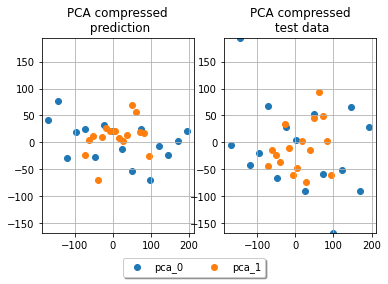

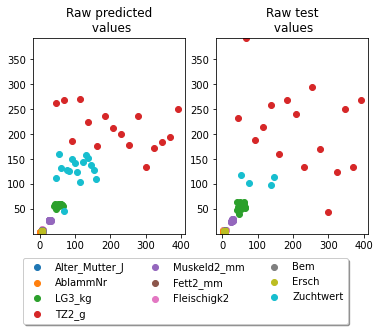

In [3]:
#InferPhenotypes().create_random_values()
pred_compr = InferPhenotypes().correlation_of_input_variables(selected_model="elastic")["Predictions"]
test_compr = pd.DataFrame(
    data=InferPhenotypes().correlation_of_input_variables(selected_model="elastic")["True values compressed"],
    columns=pred_compr.columns
)
fig, (ax1, ax2) = plt.subplots(1,2)
l_min = []
l_max = []
for column in pred_compr.columns:
    abs_min = pd.concat([pred_compr[column], test_compr[column]]).min()
    l_min.append(abs_min)
    abs_max = pd.concat([pred_compr[column], test_compr[column]]).max()
    l_max.append(abs_max)
    ax1.scatter(
        np.linspace(
            abs_min, 
            abs_max, 
            len(pred_compr[column])), 
        pred_compr[column],
        label=column
    )
    ax2.scatter(
        np.linspace(
            abs_min, 
            abs_max, 
            len(test_compr[column])), 
        test_compr[column],
        label=column
    )
ax1.set_ylim(min(l_min), max(l_max))
ax2.set_ylim(min(l_min), max(l_max))
ax1.set_title("PCA compressed\n prediction")
ax2.set_title("PCA compressed\n test data")
box1 = ax1.get_position()
box2 = ax2.get_position()
ax1.set_position([box1.x0, box1.y0 + box1.height * 0.1, box1.width, box1.height * 0.9])
ax2.set_position([box2.x0, box2.y0 + box2.height * 0.1, box2.width, box2.height * 0.9])
ax1.legend(loc='upper center', bbox_to_anchor=(1, -0.1), fancybox=True, shadow=True, ncol=3)
test_uncompr = InferPhenotypes().correlation_of_input_variables(selected_model="lasso")["True values uncompressed"]
pred_uncompr = InferPhenotypes().correlation_of_input_variables(selected_model="lasso")["Results"]
ax1.legend(loc='upper center', bbox_to_anchor=(1, -0.1), fancybox=True, shadow=True, ncol=2)
ax1.grid()
ax2.grid()
fig_, (ax1_, ax2_) = plt.subplots(1,2)
_l_min = []
_l_max = []
for _column in pred_uncompr:
    _abs_min = pd.concat([pred_uncompr[_column], test_uncompr[_column]]).min()
    _l_min.append(_abs_min)
    _abs_max = pd.concat([pred_uncompr[_column], test_uncompr[_column]]).max()
    _l_max.append(_abs_max)
    ax1_.scatter(
        np.linspace(
            _abs_min, 
            _abs_max, 
            len(pred_uncompr[_column])), 
        pred_uncompr[_column], 
        label=_column
    )
    ax2_.scatter(
        np.linspace(
            _abs_min, 
            _abs_max, 
            len(test_uncompr[_column])), 
        test_uncompr[_column], 
        label=_column
    )
ax1_.set_ylim(min(_l_min), max(_l_max))
ax2_.set_ylim(min(_l_min), max(_l_max))
ax1_.set_title("Raw predicted\n values")
ax2_.set_title("Raw test\n values")
box1_ = ax1_.get_position()
box2_ = ax2_.get_position()
ax1_.set_position([box1_.x0, box1_.y0 + box1_.height * 0.1, box1_.width, box1_.height * 0.9])
ax2_.set_position([box2_.x0, box2_.y0 + box2_.height * 0.1, box2_.width, box2_.height * 0.9])
ax1_.legend(loc='upper center', bbox_to_anchor=(1, -0.1), fancybox=True, shadow=True, ncol=3)

In [2]:
df = pd.DataFrame()
metadata = InferPhenotypes().correlation_of_input_variables(selected_model="elastic")
true_values = metadata["True values uncompressed"]
estimated_values = metadata["Results"]
randomized = pd.DataFrame(columns=estimated_values.columns, index=estimated_values.index)
for c in estimated_values.columns:
    randomized[c] = estimated_values[c] * np.random.normal(11, 4, len(metadata["Results"].index))/10
std_true = true_values.std(axis=0)
std_true.name = "Measured values standard deviation"
std_estimated = randomized.std(axis=0)
std_estimated.name = "Estimated values standard deviation"
mean_true = true_values.mean(axis=0)
mean_true.name = "Measured values mean"
mean_estimated = randomized.mean(axis=0)
mean_estimated.name = "Estimated values mean"
df = pd.concat([df, std_true], axis=1)
df = pd.concat([df, std_estimated], axis=1)
df = pd.concat([df, mean_true], axis=1)
df = pd.concat([df, mean_estimated], axis=1)
df.dropna(how="any", axis=0, inplace=True)
df

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Measured values standard deviation  \
GebGew_kg                                 0.121268   
Alter_Mutter_J                            0.992620   
AblammNr                                  1.067570   
LG3_kg                                    8.121096   
TZ2_g                                    81.149599   
Muskeld2_mm                               3.513629   
Fett2_mm                                  1.622453   
Fleischigk2                               0.586894   
Bem                                       1.089410   
Ersch                                     1.625687   
Zuchtwert                                14.053469   

                Estimated values standard deviation  Measured values mean  \
GebGew_kg                                  2.268030              4.970588   
Alter_Mutter_J                             1.708035              3.117647   
AblammNr                                   1.722933              2.529412   
LG3_kg                                    34.018312             56.029412   
TZ2_g                                     64.730200            235.411765   
Muskeld2_mm                                8.937392             27.705882   
Fett2_mm                                   2.457394              6.588235   
Fleischigk2                                4.768622              7.800000   
Bem                                        3.181105              6.571429   
Ersch                                      1.889220              5.214286   
Zuchtwert                                 59.935061            114.500000   

                Estimated values mean  
GebGew_kg                    6.045391  
Alter_Mutter_J               4.891853  
AblammNr                     3.749542  
LG3_kg                      71.126206  
TZ2_g                      205.039478  
Muskeld2_mm                 30.114122  
Fett2_mm                     6.542982  
Fleischigk2                  8.042765  
Bem                          7.652146  
Ersch                        6.929388  
Zuchtwert                  135.512700

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/sklearn/linear_model/_least_angle.py:577: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=8.498e+00, with an active set of 4 regressors, and the smallest cholesky pivot element being 8.429e-

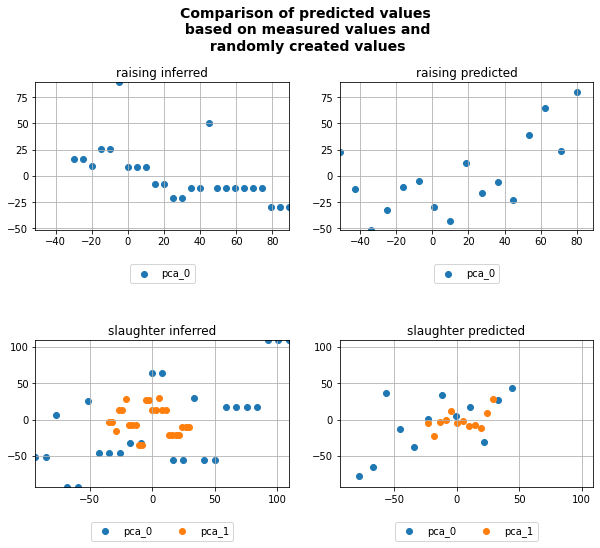

In [11]:
_d2 = InferPhenotypes().shd.model(selected_model="lasso")["Prediction"]
_d = InferPhenotypes().infer_data(selected_model="lasso")["Infer-Results"]
pattern = re.compile(r"pca\_[0-9]+")
_d2 = _d2.loc[:,list(filter(pattern.match, _d2.columns))]
fig, axes = plt.subplots(2, 2, figsize=(10, 15))
fig.subplots_adjust(top=0.5)
i = 0
for measure in np.unique(_d.columns.get_level_values("Measure")):
    __d = _d.loc[:,pd.IndexSlice[measure,:]].dropna(axis=1, how="all")
    __d2 = _d2.loc[pd.IndexSlice[measure,:],:].dropna(axis=1, how="all")
    _min = []
    _max = []
    if isinstance(__d, pd.DataFrame) and isinstance(__d2, pd.DataFrame):
        for column in np.unique(__d.columns.get_level_values(1)):
            __d_ = __d.loc[:,pd.IndexSlice[measure,column]]
            __d2_ = __d2.loc[pd.IndexSlice[measure,:],column]
            axes[i, 0].scatter(
                np.linspace(
                    np.min(__d_.values), 
                    np.max(__d_.values), 
                    len(__d_.index)), 
                __d_, label=column
            )
            axes[i, 0].set_title(f"{measure} inferred")
            axes[i, 1].scatter(
                np.linspace(
                    np.min(__d2_.values), 
                    np.max(__d2_.values), 
                    len(__d2_.index)), 
                __d2_, label=column
            )
            axes[i, 1].set_title(f"{measure} predicted")
            _min.append(np.min(__d_.values))
            _min.append(np.min(__d2_.values))
            _max.append(np.max(__d_.values))
            _max.append(np.max(__d2_.values))
    else:
        axes[i, 0].scatter(
            np.linspace(
                np.min(__d.values), 
                np.max(__d.values), 
                len(__d.index)), 
            __d, label=column
        )
        axes[i, 0].set_title(f"{measure} inferred")
        axes[i, 1].scatter(
            np.linspace(
                np.min(__d2.values), 
                np.max(__d2.values), 
                len(__d2.index)), 
            __d2, label=column
        )
        
        axes[i, 1].set_title(f"{measure} predicted")
        _min.append(np.min(__d.values))
        _min.append(np.min(__d2.values))
        _max.append(np.max(__d.values))
        _max.append(np.max(__d2.values))
    box1 = axes[i, 0].get_position()
    box2 = axes[i, 1].get_position()
    axes[i, 0].set_position([box1.x0, box1.y0 + box1.height * 0.1, box1.width, box1.height * 0.9])
    axes[i, 1].set_position([box2.x0, box2.y0 + box2.height * 0.1, box2.width, box2.height * 0.9])
    axes[i, 0].set_xlim(min(_min), max(_max))
    axes[i, 1].set_xlim(min(_min), max(_max))
    axes[i, 0].set_ylim(min(_min), max(_max))
    axes[i, 1].set_ylim(min(_min), max(_max))
    axes[i, 0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    axes[i, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)
    axes[i, 0].grid()
    axes[i, 1].grid()
    i += 1
plt.suptitle("Comparison of predicted values\n based on measured values and\n randomly created values", y=0.57, fontsize=14, fontweight="bold")
plt.subplots_adjust(hspace=0.75)
#plt.savefig("../Paper/Inferring of data sets for phenotypic data/Distribution-Comparison.pgf", bbox_inches='tight')

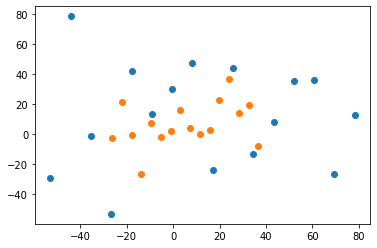

In [4]:
dset = SheepData().stratified_data()
x_cols = pd.read_csv(
    os.path.join(SheepData().sheep_folder, "model/slaughter/X-Variable.csv"), 
    index_col=0, 
    header=0
)
values = dset[1].loc[:,x_cols.values.reshape(1,-1)[0]]
r = pd.DataFrame(
    columns=[x.split(".")[0] for x in os.listdir(os.path.join(SheepData().sheep_folder, "model/slaughter/unsorted/")) if ".joblib" in x],
    index=values.index
)
for model in [x for x in os.listdir(os.path.join(SheepData().sheep_folder, "model/slaughter/unsorted/")) if ".joblib" in x]:
    _model = joblib.load(
        os.path.join(SheepData().sheep_folder, "model/slaughter/unsorted/", model)
    )
    r.loc[:,model.split(".")[0]] = _model.predict(values.fillna(0))
fig, ax = plt.subplots()
for column in r.columns:
    ax.scatter(
        np.linspace(np.min(r[column]), np.max(r[column]), len(r.index)),
        r[column], label=column
    )

In [7]:
_dset = InferPhenotypes().create_random_values(selected_model="lasso")

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/sklearn/linear_model/_least_angle.py:577: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.111e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/sklearn/linear_model/_least_angle.py:577: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.554e-01, with an active set of 4 regressors, and th

In [7]:
_dset.loc[:,x_cols.values.reshape(1,-1)[0]]
__r = pd.DataFrame(columns=["Mean", "Std"], index=_dset.columns, dtype=np.float)
__r["Mean"] = _dset.mean(axis=0).round(2)
__r["Std"] = _dset.std(axis=0).round(2)
__r.columns = pd.MultiIndex.from_arrays(
    [list(itertools.repeat("Random", len(__r.columns))), __r.columns], 
    names=["Type", "calc"]
)
__r1 = pd.DataFrame(columns=["Mean", "Std"], index=dset[0].columns, dtype=np.float)
dset[0].fillna(0, inplace=True)
__r1["Mean"] = dset[0].mean(axis=0).round(2)
__r1["Std"] = dset[0].std(axis=0).round(2)
__r1.columns = pd.MultiIndex.from_arrays(
    [list(itertools.repeat("Measured", len(__r1.columns))), __r1.columns], 
    names=["Type", "calc"]
)
total = pd.concat([__r, __r1], axis=1)
total.loc[:,"Diff"] = total.loc[:,pd.IndexSlice["Random", "Mean"]] - total.loc[:,pd.IndexSlice["Measured","Mean"]]
total = total.round(2)
total.dtype = np.float
total

Type            Random              Measured                  Diff
calc              Mean     Std          Mean           Std        
Nummer             inf     NaN  2.760101e+14  1.992613e+06     inf
Vater              inf     NaN  3.362861e+14  1.730020e+14     inf
Mutter             inf     NaN  3.057939e+14  1.261676e+14     inf
Alter2_Tage     149.31   17.97  1.596300e+02  1.558000e+01  -10.32
Alter3_Tage     156.31   17.97  1.666300e+02  1.558000e+01  -10.32
Gebmonat          1.48    0.50  1.230000e+00  4.300000e-01    0.25
Gebtyp            1.98    0.82  2.010000e+00  4.600000e-01   -0.03
Alter1_Tage      93.31   17.97  1.036300e+02  1.558000e+01  -10.32
LG1_kg           43.43   10.19  4.286000e+01  8.080000e+00    0.57
Rasse             2.80    1.22  2.810000e+00  1.220000e+00   -0.01
Muskeld1_mm      28.01    6.20  2.758000e+01  3.970000e+00    0.43
Fettd1_mm         6.15    1.73  5.860000e+00  1.150000e+00    0.29
Fleischigk1       6.56    1.71  6.480000e+00  9.600000e-01    0.08
GebGew_kg         1.65    2.34           NaN           NaN     NaN
Alter_Mutter_J    2.00    1.42  3.850000e+00  1.750000e+00   -1.85
AblammNr          1.00    1.42  3.210000e+00  1.700000e+00   -2.21
LG3_kg           18.39   26.11  5.652000e+01  8.510000e+00  -38.13
TZ2_g            67.96  101.82  2.156400e+02  7.154000e+01 -147.68
Muskeld2_mm       9.00   12.76  2.729000e+01  3.110000e+00  -18.29
Fett2_mm          2.02    2.87  6.300000e+00  1.110000e+00   -4.28
Fleischigk2       1.42    3.06  4.120000e+00  3.820000e+00   -2.70
Bem               0.93    2.30  6.370000e+00  1.720000e+00   -5.44
Ersch             0.85    2.09  5.530000e+00  1.860000e+00   -4.68
Zuchtwert        32.67   47.03  4.336000e+01  5.764000e+01  -10.69
Sgwarm_kg          NaN     NaN  1.467000e+01  1.338000e+01     NaN
Sgkalt_kg          NaN     NaN  1.398000e+01  1.278000e+01     NaN
Nettozun           NaN     NaN  8.610000e+01  7.889000e+01     NaN
Sklaenge_cm        NaN     NaN  2.347000e+01  2.098000e+01     NaN
Schulterb_cm       NaN     NaN  1.202000e+01  1.078000e+01     NaN
Keulenu_cm         NaN     NaN  3.970000e+01  3.546000e+01     NaN
Keulenb_cm         NaN     NaN  1.321000e+01  1.181000e+01     NaN
Nierenf_g          NaN     NaN  1.482300e+02  1.496300e+02     NaN
Ofettd_cm          NaN     NaN  2.700000e-01  2.900000e-01     NaN

In [60]:
d = InferPhenotypes().reverse_pca_to_original(selected_model="lasso", lenght_of_new=200)

/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/sklearn/linear_model/_least_angle.py:577: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 3 iterations, i.e. alpha=1.111e+00, with an active set of 3 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
  ConvergenceWarning)
/home/thomas/Programmieren/Analyses/lib64/python3.6/site-packages/sklearn/linear_model/_least_angle.py:577: ConvergenceWarning: Regressors in active set degenerate. Dropping a regressor, after 4 iterations, i.e. alpha=5.554e-01, with an active set of 4 regressors, and th

In [6]:
#d.loc[:,['Sgwarm_kg', 'Sgkalt_kg', 'Nettozun', 'Sklaenge_cm', 'Schulterb_cm','Keulenu_cm', 'Keulenb_cm', 'Nierenf_g', 'Ofettd_cm']]
import datetime

d.to_csv(f"../Daten/Schafe/2020-07-01-Generic-Data.csv")